In [ ]:
library(sicegar)
library(dplyr)
library(tibble)
library(tidyr)
library(readr)
library(stringr)
library(purrr)
library(here)
library(lubridate)
library(ggplot2)
library(scales)



# Data Import and Preparation

We are working with 21 years of data 2000-2020, 14 stations and 3 species leading to a total of 882 data sets.

In [ ]:
pollen_daily <- read_delim(paste0(here(), "/data/dwh/pollen_dwh_daily.txt"), delim = " ", skip = 17, trim_ws = TRUE)
pollen_daily %<>% 
    mutate(across(where(is.numeric), ~ if_else(. < 0, NA_real_, .)),
    datetime = ymd_hm(paste0(YYYY, "-", sprintf("%02d", MM), "-", sprintf("%02d", DD), " ", sprintf("%02d", HH), ":", sprintf("%02d", mm))),
    year = year(datetime)) %>%
    filter(year <= 2020) %>%
    select(-(YYYY:mm)) %>%
    setNames(tolower(names(.))) %>%
    pivot_longer(plo:pcf, names_to = "station", values_to = "conc")

pollen_split <- pollen_daily %>%
    split(list(.$year, .$station, .$parameter))

larger_ten <- function(x) x > 0
season_start <- map(pollen_split, ~detect_index(replace(.x$conc, is.na(.x$conc), 0), larger_ten))
season_end <- map(pollen_split, ~detect_index(replace(.x$conc, is.na(.x$conc), 0), larger_ten, .dir = "backward"))




Warning message:
“ 252 failed to parse.”
Warning message:
“Removed 28701 rows containing missing values (position_stack).”
Warning message:
“Removed 28696 rows containing missing values (position_stack).”


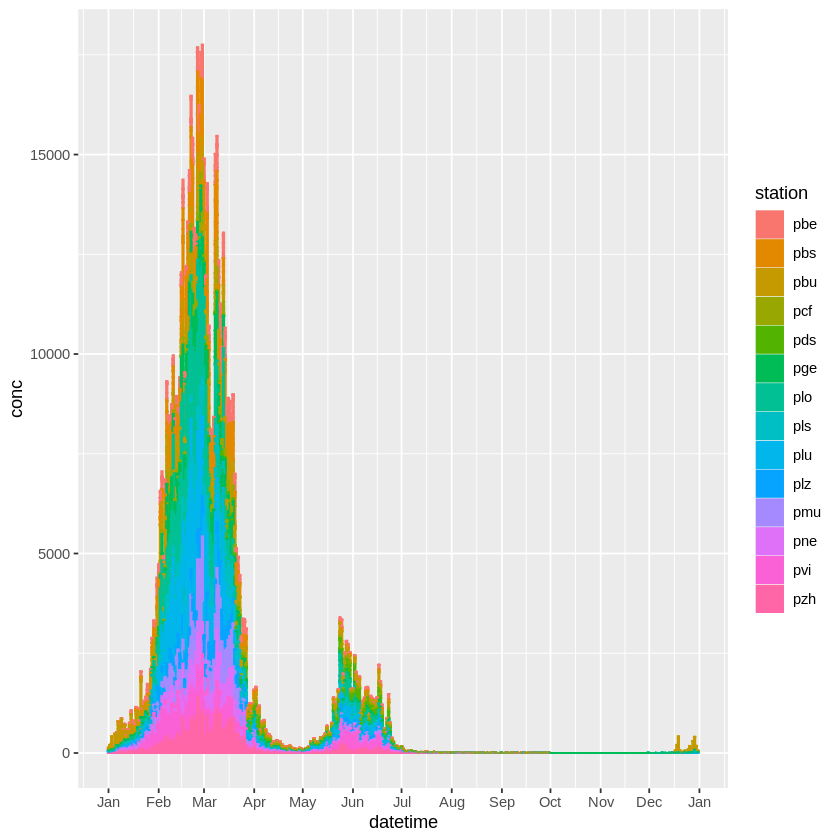

Warning message:
“Removed 28684 rows containing missing values (position_stack).”


$ALNU24

$BETU24

$POAC24


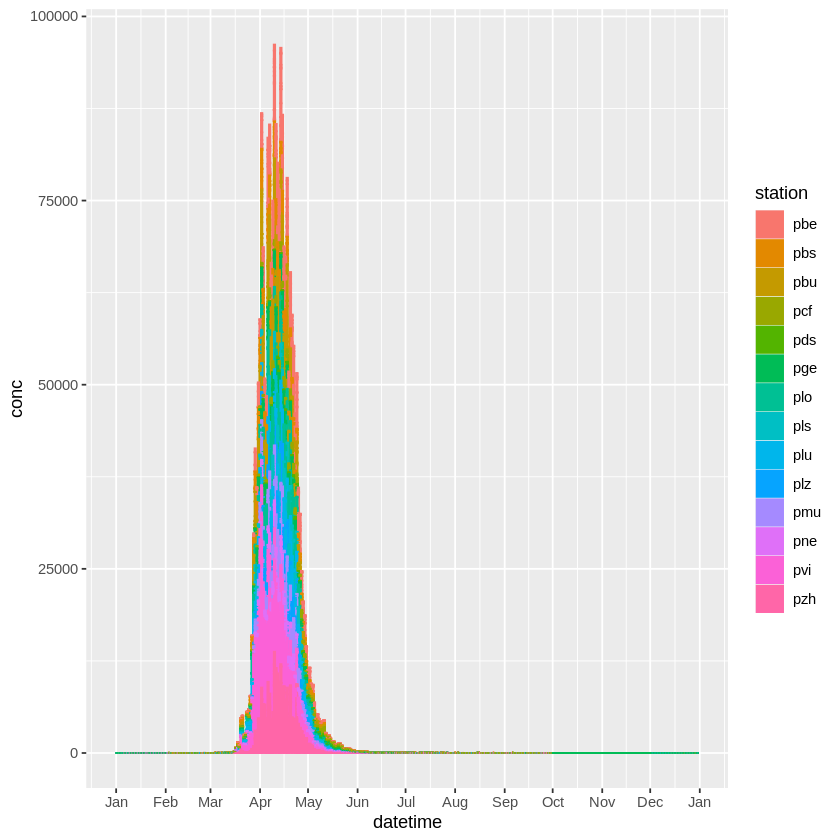

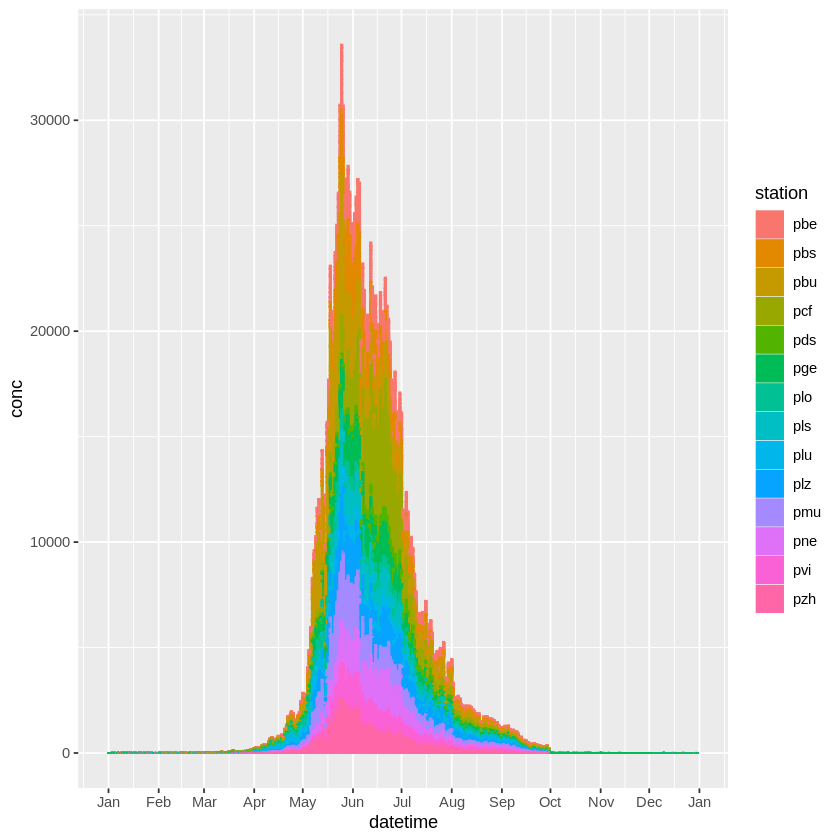

In [21]:
pollen_monthday <- pollen_daily %>%
  mutate(monthday = paste0(sprintf("%02d", month(datetime)), sprintf("%02d", day(datetime))),
         datetime = ymd(paste0("2001", monthday))) %>%
    # filter(monthday != "0229") %>%
    split(.$parameter)

map(pollen_monthday, ~ .x %>%
  ggplot(aes(x = datetime, y = conc)) +
    geom_col(aes(fill = station, col = station)) +
    scale_x_date(date_labels = "%b", date_breaks = "1 month"))

In [ ]:
pollen_season <- pmap(list(pollen_split, season_start, season_end), ~
  ..1 %>%
    slice(..2:..3) %>%
    rowid_to_column("day")) 

# This takes 100sek, wondering whether there is a more efficient solution
pollen_join <- pollen_season %>% bind_rows()

In [ ]:
pollen_mean_species <- pollen_join %>%
  group_by(day, parameter, station) %>%
  summarise(conc = mean(conc, na.rm = TRUE)) %>%
  ungroup %>%
  split(.$parameter)


## Timeseries 

this too

In [ ]:
map(pollen_mean_species, ~
    ggplot(.x, aes(x = day, y = conc, col = station, fill = station)) +
    geom_col() +
    ggtitle(paste("Average Daily", unique(.x$parameter), "Pollen Concentrations for the years 2000-2020")))

In [ ]:
pollen_sum_day <- map(pollen_mean_species, ~ .x %>%
  group_by(day, parameter) %>%
  summarise(conc = sum(conc, na.rm = TRUE)) %>%
  ungroup %>%
  mutate(conc = case_when(parameter == "ALNU24" ~ rescale(conc, to = c(0, 1.28)),
                          parameter == "BETU24" ~ rescale(conc, to = c(0, 1.20)),
                          parameter == "POAC24" ~ rescale(conc, to = c(0, 1.33)))) %>%
  select(time = day, intensity = conc))



In [ ]:
fit_curve <- function(x) {
  normalizedInput <- normalizeData(dataInput = x, 
                                   dataInputName = "doubleSigmoidalSample")
  # Fit double-sigmoidal model
  doubleSigmoidalModel <- multipleFitFunction(dataInput = normalizedInput,
                                              model = "doublesigmoidal",
                                              n_runs_min = 20,
                                              n_runs_max = 500,
                                              showDetails = FALSE)                                                
  # Calculate additional parameters
  doubleSigmoidalModel <- parameterCalculation(doubleSigmoidalModel)

  # Plotting the model
  plot <- figureModelCurves(dataInput = normalizedInput,
      doubleSigmoidalFitVector = doubleSigmoidalModel,
      showParameterRelatedLines = TRUE) + 
    scale_y_continuous(breaks = seq(0, 1.2, 0.2))


  # Table with parameters
  params <- parameterCalculation(doubleSigmoidalModel)
  params %<>% 
    mutate(across(everything(), as.character)) %>%
    pivot_longer(everything())

  return(list(plot, params))

}
fitted_curves <- map(pollen_sum_day, ~ fit_curve(.x))

# Display optimized for Jupyter Notebooks
fitted_curves



## Comparison with the curves currently used in COSMO
The first factor is a scaling factor
The second factor describes the ascending slope
The third factor describes the descendig slope


For the double-sigmoidal model, key parameters describing the curve are:

    maximum: The maximum intensity the double-sigmoidal curve reaches.
    final asymptotic intensity: The intensity the curve decreases to after having reached its maximum.
    midpoint 1: The time point at which the double-sigmoidal curve reaches half of its maximum intensity during the initial rise.
    slope 1: The slope at midpoint 1.
    midpoint 2: The time point at which the double-sigmoidal curve reaches the intensity corresponding to the mean of the maximum intensity and the final asymptotic intensity.
    slope 2: The slope at midpoint 2.

https://cran.r-project.org/web/packages/sicegar/vignettes/introduction.html

In [ ]:
# ALNUS

params_alnus <- fitted_curves[["ALNU24"]][[2]]
max_length <- params_alnus %>% filter(name == "endDeclinePoint_x")  %>% pull(value) %>% as.numeric()
midpoint1 <- params_alnus %>% filter(name == "midPoint1Param_Estimate")  %>% pull(value) %>% as.numeric()
slope1 <- params_alnus %>% filter(name == "slope1Param_Estimate")  %>% pull(value) %>% as.numeric()
midpoint2 <- midpoint1 + params_alnus %>% filter(name == "midPointDistanceParam_Estimate")  %>% pull(value) %>% as.numeric()
slope2 <- params_alnus %>% filter(name == "slope2Param_Estimate")  %>% pull(value) %>% as.numeric()
maximum <- params_alnus %>% filter(name == "maximum_Estimate")  %>% pull(value) %>% as.numeric()

x <- 1:100
saisl  <- 20

slope1_adj = slope1 * max_length / saisl
slope2_adj = slope2 * max_length / saisl
midpoint1_adj = midpoint1 * saisl / max_length
midpoint2_adj = midpoint2 * saisl / max_length
maximum_adj = maximum + 0.15 * (max_length / saisl)^(1/4)

y_new_fit <- ((maximum_adj)/(1 + exp((-slope1_adj) * (x - midpoint1_adj)))) *
             ((maximum_adj)/(1 + exp((slope2_adj) * (x - midpoint2_adj))))

y_cosmo <- (exp(-0.152 * saisl + 6) + 1) * (1 / (1 + exp(-x * 0.3 + 7))) * 
           (1 / (1 + exp(17 / saisl * x - 12)) - 0.005)

data_curves <- tibble(x, y = y_cosmo, col = "Cosmo") %>%
  bind_rows(tibble(x, y = y_new_fit, col = "New Fit"))

fitted_curves[["ALNU24"]][[1]] +
  scale_x_continuous(limits = c(0, 100)) +
  geom_line(data = data_curves, aes(x = x, y = y, col = col)) + 
  theme_minimal()

tibble(name = c("max_length", "slope1", "midpoint1", "slope2", "midpoint2", "maximum"),
       orig = c(max_length, slope1, midpoint1, slope2, midpoint2, maximum),
       adj = c(max_length, slope1_adj, midpoint1_adj, slope2_adj, midpoint2_adj, maximum_adj))

In [ ]:
# BETULA

params_alnus <- fitted_curves[["BETU24"]][[2]]
max_length <- params_alnus %>% filter(name == "endDeclinePoint_x")  %>% pull(value) %>% as.numeric()
midpoint1 <- params_alnus %>% filter(name == "midPoint1Param_Estimate")  %>% pull(value) %>% as.numeric()
slope1 <- params_alnus %>% filter(name == "slope1Param_Estimate")  %>% pull(value) %>% as.numeric()
midpoint2 <- midpoint1 + params_alnus %>% filter(name == "midPointDistanceParam_Estimate")  %>% pull(value) %>% as.numeric()
slope2 <- params_alnus %>% filter(name == "slope2Param_Estimate")  %>% pull(value) %>% as.numeric()
maximum <- params_alnus %>% filter(name == "maximum_Estimate")  %>% pull(value) %>% as.numeric()

x <- 1:100
saisl  <- 80

y_cosmo <- 2 * (1 / (1 + exp(- x *0.5)) - 0.5) * exp(-((0.08 * x - 0.8) * 
(0.08 * x - 0.8)))* (1/(1 + exp((log(39) + 8)/saisl * x - 8)) - 0.025)

midpoint1_adj = midpoint1 * saisl / max_length
midpoint2_adj = midpoint2 * saisl / max_length
slope2_adj = slope2 * (max_length / saisl)^2
maximum_adj = maximum + 0.35 * sqrt(max_length / saisl)

y_new_fit <- ((maximum_adj)/(1 + exp((-slope1) * (x - midpoint1_adj)))) *
             ((maximum_adj)/(1 + exp((slope2_adj) * (x - midpoint2_adj))))

data_curves <- tibble(x, y = y_cosmo, col = "Cosmo") %>%
  bind_rows(tibble(x, y = y_new_fit, col = "New Fit"))

max_length
slope1_adj
slope2_adj

fitted_curves[["BETU24"]][[1]] +
  scale_x_continuous(limits = c(0, 100)) +
  geom_line(data = data_curves, aes(x = x, y = y, col = col)) + 
  theme_minimal()

In [ ]:
# POACEAE

params_alnus <- fitted_curves[["POAC24"]][[2]]
max_length <- params_alnus %>% filter(name == "endDeclinePoint_x")  %>% pull(value) %>% as.numeric()
midpoint1 <- params_alnus %>% filter(name == "midPoint1Param_Estimate")  %>% pull(value) %>% as.numeric()
slope1 <- params_alnus %>% filter(name == "slope1Param_Estimate")  %>% pull(value) %>% as.numeric()
midpoint2 <- midpoint1 + params_alnus %>% filter(name == "midPointDistanceParam_Estimate")  %>% pull(value) %>% as.numeric()
slope2 <- params_alnus %>% filter(name == "slope2Param_Estimate")  %>% pull(value) %>% as.numeric()
maximum <- params_alnus %>% filter(name == "maximum_Estimate")  %>% pull(value) %>% as.numeric()

x <- 1:250
saisl  <- 100

y_cosmo <- 1.03 * (1/(1 + exp(-0.3 * x + 3.5)) - 0.03)* 
          (1/(1 + exp((log(499) + 8)/saisl * x - 7)) - 0.001)

midpoint1_adj = midpoint1 * saisl / max_length
midpoint2_adj = midpoint2 * saisl / max_length
maximum_adj = maximum +  0.01 * max_length / saisl 

y_new_fit <- ((maximum_adj)/(1 + exp((-slope1) * (x - midpoint1_adj)))) *
             ((maximum_adj)/(1 + exp((slope2) * (x - midpoint2_adj))))


data_curves <- tibble(x, y = y_cosmo, col = "Cosmo") %>%
  bind_rows(tibble(x, y = y_new_fit, col = "New Fit"))

maximum_adj
slope1
midpoint1_adj
slope2
midpoint2_adj

fitted_curves[["POAC24"]][[1]] +
  scale_x_continuous(limits = c(0, 250)) +
  geom_line(data = data_curves, aes(x = x, y = y, col = col)) + 
  theme_minimal()

In [ ]:
sigmoidalFitFormula

In [ ]:
doublesigmoidalFitFormula